In [2]:
%matplotlib inline

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import time
plt.ion()   

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [4]:
path = 'something/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

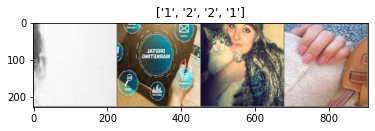

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
_model = models.resnet18(pretrained=True)
_model = nn.Sequential(*list(_model.children())[:-1])



In [8]:
list(_model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8878 Acc: 0.4784
val Loss: 1.2143 Acc: 0.3636

Epoch 1/24
----------
train Loss: 0.7819 Acc: 0.6118
val Loss: 0.5679 Acc: 0.7273

Epoch 2/24
----------
train Loss: 0.7883 Acc: 0.5961
val Loss: 0.6118 Acc: 0.6860

Epoch 3/24
----------
train Loss: 0.8365 Acc: 0.6118
val Loss: 0.6425 Acc: 0.6529

Epoch 4/24
----------
train Loss: 0.7759 Acc: 0.6078
val Loss: 0.6827 Acc: 0.6529

Epoch 5/24
----------
train Loss: 0.6608 Acc: 0.6706
val Loss: 0.6964 Acc: 0.7190

Epoch 6/24
----------
train Loss: 0.6221 Acc: 0.7294
val Loss: 0.6741 Acc: 0.7025

Epoch 7/24
----------
train Loss: 0.4752 Acc: 0.7529
val Loss: 0.7212 Acc: 0.6446

Epoch 8/24
----------
train Loss: 0.4785 Acc: 0.7922
val Loss: 0.6462 Acc: 0.7107

Epoch 9/24
----------
train Loss: 0.4439 Acc: 0.8118
val Loss: 0.6133 Acc: 0.7190

Epoch 10/24
----------
train Loss: 0.4713 Acc: 0.7686
val Loss: 0.6767 Acc: 0.7190

Epoch 11/24
----------
train Loss: 0.4267 Acc: 0.8118
val Loss: 0.6240 Acc: 0.7190

Ep

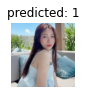

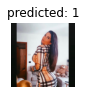

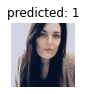

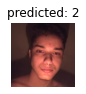

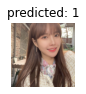

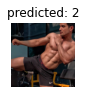

In [10]:
visualize_model(model_ft)

In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0106 Acc: 0.4941
val Loss: 0.7554 Acc: 0.5289

Epoch 1/24
----------
train Loss: 0.9058 Acc: 0.5137
val Loss: 0.8480 Acc: 0.4380

Epoch 2/24
----------
train Loss: 0.7149 Acc: 0.6196
val Loss: 0.5883 Acc: 0.7190

Epoch 3/24
----------
train Loss: 0.7694 Acc: 0.6314
val Loss: 0.6150 Acc: 0.7107

Epoch 4/24
----------
train Loss: 0.8080 Acc: 0.5725
val Loss: 0.5870 Acc: 0.7025

Epoch 5/24
----------
train Loss: 0.6545 Acc: 0.6824
val Loss: 1.0541 Acc: 0.4545

Epoch 6/24
----------
train Loss: 0.8100 Acc: 0.6353
val Loss: 0.6644 Acc: 0.6777

Epoch 7/24
----------
train Loss: 0.6476 Acc: 0.6784
val Loss: 0.7006 Acc: 0.6364

Epoch 8/24
----------
train Loss: 0.5505 Acc: 0.7412
val Loss: 0.7595 Acc: 0.6198

Epoch 9/24
----------
train Loss: 0.6216 Acc: 0.6627
val Loss: 0.7485 Acc: 0.6281

Epoch 10/24
----------
train Loss: 0.6240 Acc: 0.6588
val Loss: 0.6527 Acc: 0.6777

Epoch 11/24
----------
train Loss: 0.5661 Acc: 0.7137
val Loss: 0.6851 Acc: 0.6694

Ep

In [10]:

model_conv = _model

from PIL import Image
start_time = time.time()

input_image = Image.open('photo916.jpg')

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model_conv.to('cuda')

with torch.no_grad():
    output = model_conv(input_batch)


# probabilities = torch.nn.functional.softmax(output[0], dim=0)

# print(probabilities)
# print("--- %s seconds ---" % (time.time() - start_time))


In [34]:
output.shape

torch.Size([1, 512, 1, 1])

In [20]:
modelpath = os.getcwd()
torch.save(model_conv.state_dict(), "model.pth")

In [31]:
# dataset:
#- 512 - resnet18 output
# - 1 - n_subscribers
# - 1 - n_likes



# df = pd.read_pickle('data.pickle')
# data = df.values

data = np.random.randn(100, 513)
data = torch.as_tensor(data).float()

dataset = torch.utils.data.TensorDataset(data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=5)

class BaselineNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(512, 20)
        self.fc2 = nn.Linear(20 + 1, 1)
        
    def forward(self, resnet_features, user_features):
        # resnet_features B x 512
        # user_features B x 1
        x = self.fc1(resnet_features) # B x 20
        x = torch.cat([x, user_features], dim=1) # B x 21
        x = nn.functional.relu(x) # B x 21
        x = self.fc2(x) # B x 1
        return x

    
net = BaselineNet()
batch = next(iter(dataloader))
resnet_features, user_features, gt = batch[0][:, :512], batch[0][:, 512:513], batch[0][:, 513:]
res = net(resnet_features, user_features)

loss = nn.MSELoss()

print(res)

tensor([[ 0.3942],
        [ 0.1443],
        [ 0.2519],
        [-0.1412],
        [ 0.4099]], grad_fn=<AddmmBackward>)


In [30]:
batch

[tensor([[ 0.0708,  0.0802, -0.5487,  ..., -0.4294,  0.1900,  0.1520],
         [ 0.4954, -0.0115,  0.6058,  ..., -1.4256, -0.3596,  0.3515],
         [ 1.5155,  0.7915, -0.3853,  ...,  0.8661,  0.0849, -0.2780],
         [ 1.2238, -1.5784, -0.5646,  ...,  0.2651,  0.7988,  0.0110],
         [ 0.4183, -0.2559, -0.1308,  ..., -1.4618,  0.7128,  0.0396]])]

In [17]:
data = np.random.randn(100, 513)


In [18]:
data

array([[ 1.28456228,  0.40931551,  0.73674423, ...,  0.17015216,
        -1.73066091, -0.02465989],
       [ 0.83933394, -0.23110408, -0.41641739, ...,  2.32546915,
        -0.56489181, -0.64998229],
       [ 0.89380455,  0.36915201, -0.50427125, ..., -0.48398639,
        -0.32041868, -0.4096176 ],
       ...,
       [ 1.02540934,  0.63142033, -1.23161242, ...,  0.23455468,
        -0.07116595,  0.74315135],
       [ 1.57495183, -0.13318008,  1.39191628, ..., -2.21357619,
         0.04560682,  0.55169346],
       [ 1.04501747,  1.18742502,  0.65758596, ...,  0.63118972,
         0.74983379,  1.0359573 ]])

In [35]:
model_v1 = torch.load('resnet.pt')
model_v1.eval()

c:\users\gafed\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:589: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)


RecursiveScriptModule(original_name=Sequential)

In [36]:
model_v2 = torch.load('regression.pt')
model_v2.eval()

RecursiveScriptModule(original_name=BaselineNet)

In [37]:
input_image = Image.open('photo916.jpg')

In [39]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

with torch.no_grad():
    output = model_v1(input_batch)

c:\users\gafed\appdata\local\programs\python\python36\lib\site-packages\torch\nn\modules\module.py:889: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:934.)
  result = self.forward(*input, **kwargs)


In [43]:
output

tensor([[[[1.2729e+00]],

         [[2.2017e+00]],

         [[8.4323e-01]],

         [[3.5207e-01]],

         [[5.7268e-01]],

         [[8.1045e-01]],

         [[2.8772e-01]],

         [[3.1021e-01]],

         [[1.1084e+00]],

         [[3.5749e-01]],

         [[1.0767e+00]],

         [[2.2527e-01]],

         [[5.0592e-01]],

         [[1.8816e-01]],

         [[7.2377e-01]],

         [[8.0280e-01]],

         [[1.4241e+00]],

         [[3.9689e+00]],

         [[1.4969e+00]],

         [[1.3411e+00]],

         [[1.8314e-02]],

         [[7.1491e-01]],

         [[1.6862e+00]],

         [[1.3356e+00]],

         [[4.0925e-01]],

         [[5.6727e-01]],

         [[1.1979e+00]],

         [[1.3393e+00]],

         [[5.9189e-01]],

         [[2.6228e-02]],

         [[6.7718e-01]],

         [[1.2953e-02]],

         [[7.3990e-01]],

         [[4.8494e-01]],

         [[4.2979e-01]],

         [[7.0971e-01]],

         [[9.6110e-01]],

         [[1.3385e+00]],

         [[2